This notebook was prepared by:

Jack Brennen (jpb9088@nyu.edu)

Fabrizio Cabrera (fc2250@nyu.edu)

Alex Ferrante (af3913@nyu.edu)

Graduate School of Arts and Sciences (GSAS) at New York University (NYU)

May 2022

# One Day Ahead Movement Stock Prediction - Application of Machine Learning Binary Classifiers  

In the stock market shares of firms are traded. Trading is an important feature of the economy because it gives firms access to capital in exchange for a share of ownership. Speculation in stock prices means that traders buy when they think prices are going up and sell when they think prices are going down. This would be profitable for traders making accurate predictions of stock prices. However, the predictability of stock prices has been questioned.

According to the efficient market hypothesis (EMH) the stock market follows a random walk and is inherently unpredictable (Sargent, 1986). The EMH implies that all information available today is reflected in prices of stocks today and the changes in tomorrows price will only depend on the news of tomorrow. This is because that the stock market is perceived to be very informationally efficient and comopetitive. Since we cannot predict news, stock forecasting is impossible. This would have the consequence that prices are fairly priced and one can not beat the market using current information. Burton Malkiel claims that a strong argument for the market being efficient and unpredictable is that fact that expert investors are unable to beat the market (Malkiel, 2003).

The ability to predict the movement of a stock was once far fetched, however, thanks to advancements in machine learning techniques, there is reason to believe short-run predictions are possible, within reason. So what makes stock movement prediction tricky? Well, several factors, but one which is most obscure is market noise. With most persons' having access to the internet, news spreads quickly. This means consumers' sentiments are subject to changing quickly, resulting in short-run market fluctuations. Exogenous shocks to the market come in many forms and all of which are reported on. With the rise of internet news platforms these sources server as venues for market particpants to consume stock information which subsequetly informs short-run behavior. 

Since we believe that capturing trends in agents news consumption is valuable in explaining short-run movements in stocks, this project will include data from Google Trends and Wikipedia API's to serve as indexes to inform the frequency and popularity of stock news. In addition to data collected from Google Trends and Wikipedia API's we also collect general stock data (open, close, volumem ect.). Through the use of random forrests, convolutional neural networks (CNN), and recursive neural networks (RNN) we will contruct a binary-classification task and see how accurately we can model short-run stock movement. While there are an array of targets we could test, the target for the procedding models will be whether the stock closing price will increase tomorrow (1) or whether it will decrease (0). 

Given constraints in time and computing power, we will collect data from 01/01/2019 to 03/31/2022 for Ford, Netflix, and UBS. The stocks selected cover three different industires which will allow us to tests our models preictive power in varying markets.   


## 1. Pulling Together the Data

As the saying goes, garbage in, garbage out. Thus, we gave some serious thought on how to best collect our data. This section reviews the necessary steps taken to aquire the stock and news data from their respective API's and the subsequent data cleaning procedures. Given that the web scraping process was computationally expensive, this section will display the code in its raw form. At the end of section two the cleaned and transformed CSV data files will be made available. Your computer will thank us later.

In [5]:
# Import the necessary data cleaning packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#%pip install pytrends
import pytrends
from pytrends.request import TrendReq
#%pip install pageviewapi
import pageviewapi
#%pip install yfinance
import yfinance as yf

# Import machine learning packages
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, TimeDistributed, BatchNormalization, Conv1D, MaxPooling1D, Flatten, InputLayer
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l1, l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

### 2. Data Processing - Feature and Target Creation

In this next phase of data processing we focus on using the existing data pulled to generate additional features and targets. From the Google News and Wikipedia data collected, we sum across each of the keyword list results to create two new features noted as "Wiki_total" and "Google_total", respectively. These new "total" features will then be used as denominator values and assist in creating more features which with the hope of providing greater explanantory power to our future models.   

Now that we have a comprehesive feature matrix of data, we turn to generating the targets. As mentioned, there are a variety of targets that could be tested to predict stock movement. Below we have generated five binary targets, each either related to the stock close price, open price, or volumne. For the purposes of the models developed in this project, we will focus on trying to accurately predict "target_3" - the difference in closing price. This target's result is binary where an increase in the closing price returns a value of 1 and a decrease in the closing price returns 0.

Finally, we've made it to a stage where out data set includes many features and targets to test them on. 

Below are the fully cleaned and model ready CSV files for Ford, Netflix, and UBS.

In [6]:
netflix = pd.read_csv("netflix_model_ready.csv",
                      parse_dates=True,
                      infer_datetime_format=True,
                      index_col="date")

### 3. Feature Selection 

Now that we have the data cleaned, additional features created, and targets set, we can begin to think about constucting our models. However, before jumping into deciding which model to use and the appropriate architecture for this time-series, binary classfication task, we must first give some thought to what features are going to give our models the greatest preictive power.

Taking a look first at the shape of our data, we notice that there are quite a few features present.

With 169 features in total, it is likely the case that not all variable are valuable in predicting our target. A generic, although not often recommended approach would be the kitchen sink, where all 169 features would be included in our models. While this would be simple, if we work under the assumption that some variables are not relevant in explaining our target, then this approach would negatively affect our models ability to learn since we would be introducing unnecessary noise. While there are many approaches to feature selection, we decide on the implement the following strategies:

1) SelectKBest

2) Principal Component Analysis

3) Blended - Identify the "best features" through SelectKBest, then run a PCA on those features

From the Keras "feature_selection" library, the SelectKBest function works by implementing an f-regression to identify the N number of features that have the greatest significance in explaining the identified target.  

Let's continue with using ubs as an example and see how these feature selection methodologies are implemented.

We'll first do a little more data manipulation.

In [7]:
# SelectKBest implementation

# to remove first 14 days that include NaNs due to some calculations
netflix = netflix.iloc[14:, :] 

# to remove duplicated columns
netflix = netflix.drop(["Nas_total", 'Stock_total', 'Dow_total'],axis=1) 

netflix = netflix.dropna()
netflix = netflix[~(netflix.isin([np.inf, -np.inf]).any(axis=1))] 

# Drop additional targets
netflix = netflix.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)

# Target will be 3 (close to close)
target_3_0 = netflix["target_3"]

# Print shape 
print(netflix.shape, target_3_0.shape)

# Standardize the data 
Mscaler = MinMaxScaler()
netflix = pd.DataFrame(Mscaler.fit_transform(netflix), columns = netflix.columns)

# Implement SelectKBest class to extract 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=40)
best_fit = bestfeatures.fit(netflix, target_3_0)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(netflix.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score'] 
print(features_score.nlargest(40, 'Score'))  


(707, 157) (707,)
                 Features     Score
154  Dow_Disparity_s_Move  8.787505
117              Nas_gain  6.026433
44               Wiki_RSI  5.833312
142              Dow_diff  5.682044
9                  Volume  5.502726
70             Google_RSI  5.362170
137       Dow_Disparity_s  5.089441
91             Stock_gain  4.673949
68        Google_avg_loss  4.144443
116              Nas_diff  4.097171
129          Nas_RSI_Move  4.047845
143              Dow_gain  3.798308
93         Stock_avg_gain  3.582331
153    Dow_Disparity_Move  3.572769
149              Dow_Move  3.477000
144              Dow_loss  3.418292
110         Nas_Disparity  3.371320
47       Wiki_MAvg_s_Move  2.987218
46         Wiki_MAvg_Move  2.822493
106        Nas_Moment_1_s  2.806793
113             Nas_ROC_s  2.806793
45              Wiki_Move  2.633231
151       Dow_MAvg_s_Move  2.418214
121                Nas_rs  2.337197
136         Dow_Disparity  2.294858
99      Stock_MAvg_s_Move  2.232437
2         

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Shown above the top 40 features (descending order) that have the greatest significance with respect to target 3. This list can now give us greater insight into which features should be included in model testing and which should be dropped.

Alternatively, we could use a PCA approach to reduce the dimenstionality of the data without having to necessarily hand pick features. Let's see this in action.

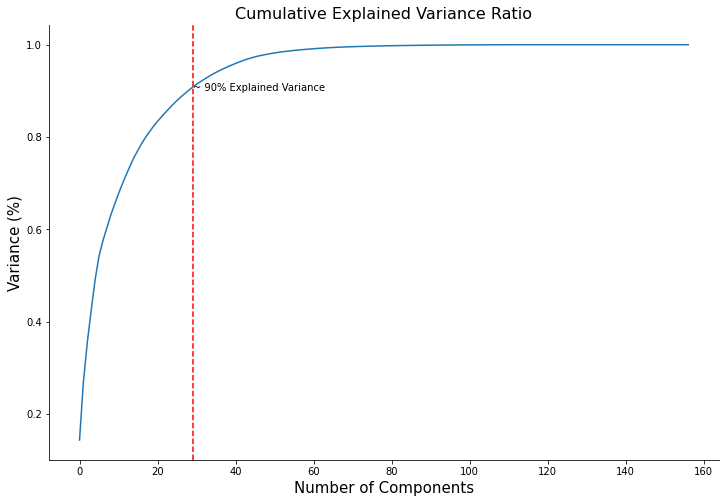

[ 14.40607419  26.98478956  35.5879882   42.54239214  49.12929689
  54.23384737  57.55797588  60.34467469  63.06674723  65.4513772
  67.76189492  69.87582048  71.90802152  73.8173129   75.6641939
  77.21255699  78.712749    80.0457416   81.2323653   82.36706913
  83.4150206   84.38173659  85.32469525  86.21577408  87.0887429
  87.9277511   88.70381704  89.42988412  90.14049892  90.80829335
  91.44243875  92.00274265  92.53886119  93.06189206  93.56969885
  94.00944962  94.44438761  94.8518504   95.233071    95.60457302
  95.95395738  96.27785267  96.59220875  96.87965554  97.13384936
  97.37510037  97.58097425  97.76141071  97.92109136  98.07541171
  98.21997533  98.34986941  98.46351683  98.56926286  98.66707337
  98.75760494  98.84436507  98.92290937  98.99448491  99.0637059
  99.12655207  99.18804581  99.24621749  99.30255795  99.35481472
  99.4000688   99.44202285  99.47980044  99.51406178  99.54419329
  99.57348857  99.60110483  99.62626045  99.64914981  99.6712031
  99.69254543  

In [8]:
# PCA implementation
pca = PCA().fit(netflix)
fig, ax = plt.subplots(figsize=(12,8))

# Display cumulated explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance Ratio', fontsize=16)
plt.xlabel('Number of Components', fontsize=(15))
plt.ylabel('Variance (%)', fontsize=(15)) 

annotation = 29
plt.axvline(annotation, color='r', linestyle='--')
plt.annotate('~ 90% Explained Variance', xy=(annotation, 0.8), xytext=(annotation, 0.9))

ax.spines[['top', 'right']].set_visible(False)

plt.show()

print(np.cumsum(pca.explained_variance_ratio_) * 100) 


From the graph depicted above, we can apply a PCA decomposition on our origional feature data and with using only 29 principal components explain approximately ~90% of the variance of our target.

In the third and final approach mentioned, we look to blend the two feature selection strategies by running a PCA decomposition, but only on the N best features found using SelectKbest. The rationale behind this blended strategy is that if we look at the bottom half of the SelectKBest results (presented above), we notice that many of the features are marginally significant in explaining the target. It could be the case that including features which have little explanitory power is causing more harm than good. Mainly, thier inclusion could introduce more noise than predicitve power. Thus, by only selecting features which have a relitively stronger and significant relationship to the target we can have greater confidence that we are mitigating the inculsion of noisy features.

In [9]:
# Apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=41)
best_fit = bestfeatures.fit(netflix, target_3_0)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(netflix.columns)

# Concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score'] 
feats_kb = list(features_score.nlargest(41, 'Score').iloc[1:41]['Features'])

# Keep only the top 40 features
netflix_best = netflix[feats_kb]

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


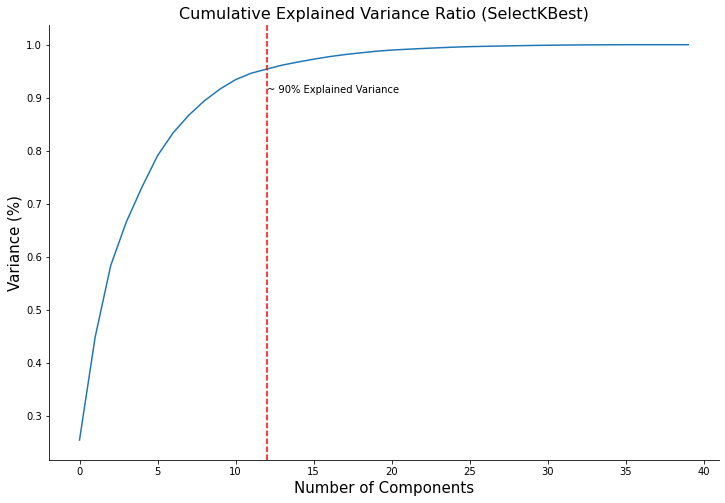

[ 25.50831731  44.87010167  58.39291288  66.6068864   73.15751889
  79.09544285  83.40293555  86.71699155  89.42762945  91.6347604
  93.41435869  94.62318049  95.41105097  96.16006587  96.73539867
  97.2637929   97.74420956  98.13821468  98.45936204  98.7672376
  98.98777371  99.141352    99.28286547  99.41712382  99.54020083
  99.63258027  99.69368895  99.75146914  99.80663708  99.85322532
  99.89461171  99.92923721  99.95070618  99.96922731  99.98300192
  99.99467237 100.         100.         100.         100.        ]


In [10]:
# PCA implementation
pca = PCA().fit(netflix_best)
fig, ax = plt.subplots(figsize=(12,8))

# Display cumulated explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance Ratio (SelectKBest)', fontsize=16)
plt.xlabel('Number of Components', fontsize=(15))
plt.ylabel('Variance (%)', fontsize=(15)) 

annotation = 12
plt.axvline(annotation, color='r', linestyle='--')
plt.annotate('~ 90% Explained Variance', xy=(annotation, 0.8), xytext=(annotation, 0.91))

ax.spines[['top', 'right']].set_visible(False)

plt.show()

print(np.cumsum(pca.explained_variance_ratio_) * 100) 

When using a PCA transform on the features found from SelectKBest, it is possible to explain ~90% of the variance with far fewer principal components. 

### 4. Model Development and Testing

In the previous section we reviewed a few of the possible feature selection techniques used by machine learning practitioners. In this section we will dive into model development and testing, where we begin to see the fruits of our computers labor. One thing to note is that each of the three algorthms presented (Random Forest, CNN'S, and RNN's) were tested using each of the feature selection methodologies. We felt that this approach would allow us to be comprehesive in finding optimal results, while also added an experimetnal element to model development. That being said, trialing feature selection approaches resulted in many models being created. In an effort to reduce unnecesary confusion, we will only present the models which generated the best results and the processes undertaken to arrive at them. Additionally, the following section will only present the code used in the development of ubs models. Results for Netlifx and UBS will be presented, however, for brevity the code will not be included. Additional code can be found on the project GitHub repository (https://github.com/fabcabrera/Stock-Predictions). 

### 4.1 Random Forest

Random forest uses several decision trees and takes the mean output of all the trees as the result. Each tree is trained randomly on a subset of the input data. Doing this removes the issue of over-training and allows for more features for a smaller performance cost (Kam Ho, 1995). 
Decision trees are flowcharts that depict outcome probabilities depending on given variables. The problem of creating such trees optimally is nondeterministic-polynomial-time complete (Hyafil, 1976) but approximate methods do exist. For example, induction of decision is a common method. With this method the set of input is divided based on some output value being above a threshold that is random. Then an input variable is chosen and a threshold set so that as many values are classified correctly as possible. This process continues recursively until all the data is classified in a correct way, or no improvement can be made (Ross Quinlan, 1986).

The following code will work through the steps taken to build our random forest. 

In [11]:
# Drop NaNs
netflix = netflix.dropna()
netflix = netflix[~(netflix.isin([np.inf, -np.inf]).any(axis=1))] 

# Generate target vector and feature matirx 
target_3 = netflix["target_3"]

# Split into training and testing sets 
column_indices = {name: i for i, name in enumerate(netflix.columns)}

n = len(netflix)

X_train = netflix[0:int(n*0.9)]
X_test = netflix[int(n*0.9):]

y_train = target_3[0:int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [12]:
# Print distirbution of target variable
counts = y_train.groupby(by = y_train).count()
counts = pd.Series(counts)
print(counts)

target_3
0.0    300
1.0    336
Name: target_3, dtype: int64


In [13]:
# Standardize the data
Mscaler = MinMaxScaler() 

X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = netflix.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = netflix.columns)

In [14]:
# Apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=41)
best_fit = bestfeatures.fit(X_train, y_train)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(netflix.columns)

# Concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score'] 
feats_kb = list(features_score.nlargest(41, 'Score').iloc[1:41]['Features'])

# Set SelectKBest to train and test data
X_train_kb = X_train[feats_kb]
X_test_kb = X_test[feats_kb]

# Apply PCA to the training and testing data
pca_kb = PCA(n_components = 12).fit(X_train_kb.to_numpy())
X_train_kb = pca_kb.transform(X_train_kb.to_numpy())
X_test_kb = pca_kb.transform(X_test_kb.to_numpy())

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [15]:
# Build Random Forest classifier
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(10, 1200, 15, dtype = int))}

clf = RandomForestClassifier()
model_kb = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
                
model_kb.fit(X_train_kb,y_train)

model_kb.best_params_

y_kb_hat = model_kb.best_estimator_.predict(X_test_kb)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [16]:
print("Random Forest Accuracy with SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat).round(4)*100))

Random Forest Accuracy with SelectKBest features: 43.66%


Using the SelectKBest to determine the 40 most significant features, our random forest model returns an accuracy score or 57%. With the basic model structure down, we can next begin to test various hyperparamters in hopes of improvinf the models predictive accuracy.

In [17]:
def kbest_creator(k, df, df_test):
    """
    Returns list of k best features and the number of efficient principle components to use with said k features
    """
    # Apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    best_fit = bestfeatures.fit(df, y_train)
    best_scores = pd.DataFrame(best_fit.scores_)
    best_columns = pd.DataFrame(netflix.columns)
    
    # Concatenate the dataframes for better visualization
    features_score = pd.concat([best_columns, best_scores], axis=1)
    features_score.columns = ['Features', 'Score']  # naming the dataframe columns
    feats_kb = list(features_score.nlargest(k, 'Score').iloc[1:k]['Features'])

    # Run PCA decomposition on the K best features
    pca = PCA().fit(df[feats_kb])
    pca_scores = np.cumsum(pca.explained_variance_ratio_) * 100
    res = next(x for x, val in enumerate(pca_scores) if val > 85)
    res = res + 1
    res
    
    pca_kb_1 = PCA(n_components = res).fit(df[feats_kb].to_numpy())
    df = pca_kb_1.transform(df[feats_kb].to_numpy())
    df_test = pca_kb_1.transform(df_test[feats_kb].to_numpy())
    
    return df, df_test

In [18]:
# Create train and test data with varying number of K best features
X_train_kb_1, X_test_kb_1, = kbest_creator(11, X_train, X_test)
X_train_kb_2, X_test_kb_2, = kbest_creator(26, X_train, X_test)
X_train_kb_3, X_test_kb_3, = kbest_creator(76, X_train, X_test)

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [19]:
# Test using 11 K best features
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(10, 1200, 15, dtype = int))}
clf = RandomForestClassifier()
model1 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
model_kb1 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)

model_kb1.fit(X_train_kb_1,y_train)

y_kb_hat_1 = model_kb1.best_estimator_.predict(X_test_kb_1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [20]:
# Test using 26 K best features
model_kb2 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
model_kb2.fit(X_train_kb_2,y_train)

y_kb_hat_2 = model_kb2.best_estimator_.predict(X_test_kb_2)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
# Test using 76 K best features
model_kb3 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
model_kb3.fit(X_train_kb_3,y_train)

y_kb_hat_3 = model_kb3.best_estimator_.predict(X_test_kb_3)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
print("Random Forest Accuracy with 11 SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat_1).round(4)*100))
print("Random Forest Accuracy with 26 SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat_2).round(4)*100))
print("Random Forest Accuracy with 76 SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat_3).round(4)*100))

Random Forest Accuracy with 11 SelectKBest features: 66.67%
Random Forest Accuracy with 26 SelectKBest features: 48.0%
Random Forest Accuracy with 76 SelectKBest features: 46.67%


While it may not be much, after a little hyperparamter tuning, we are able to increase our random forest models prediction accuracy to a modest 60%. What is interesting to note from the results is the 15% increase in the models accuracy when we go from including 11 to 26 features. However, the rate in which accuracy increases with the number of features included seems to be diminishing since the jump from 26 to 76 features leads to a decrease in model performance. This reaffirms the notion that including features with marginal explanatory power are harmful to model performance.     

Include results for Netflix and UBS here

#### 4.2 Convolutional Neural Network (CNN)

Provide description of CNN

In [ ]:
# Create train, validation and test data 
column_indices = {name: i for i, name in enumerate(netflix.columns)}

n = len(netflix)
X_train = netflix[0:int(n*0.7)]
X_val = netflix[int(n*0.7):int(n*0.9)]
X_test = netflix[int(n*0.9):]

y_train = target_3[0:int(n*0.7)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [ ]:
# Standardize the data using MinMaxScaler
X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = netflix.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = netflix.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = netflix.columns)

In [ ]:
def df_to_X_y2(df, target, window_size=5):
    """
    Generates a a timeseries window to all for prediction of future values. 
    """
    # converts to matrix of numpy arrays  
    df_as_np = df.to_numpy() 

    X = []
    y = []

    # Length of data frame - window_size so it does't take empty values at the end
    for i in range(len(df_as_np)-window_size): 
    
        # Takes row i and all rows above within the window size length
        row = [r for r in df_as_np[i:i+window_size]] 

        # Creates 3 dimentional array (obseravtions, rows in window, features)
        X.append(row)

        # Pulls the target variable after the window, target varible needs to be column zero in this 
        label = target[i+window_size] 

        # returns (N,) martix of targets i+window_length time periods away
        y.append(label) 

    return np.array(X), np.array(y)

In [ ]:
def kbest_creator(k):
    """
    Returns list of k best features and the number of efficient principle compents to use with said k features.
    Differs from the kbest_creator function in the random forest section where the only paramter now
    is k.
    """
    # Apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    best_fit = bestfeatures.fit(X_train, y_train)
    best_scores = pd.DataFrame(best_fit.scores_)
    best_columns = pd.DataFrame(netflix.columns)
    
    # Concatenate the dataframes for better visualization
    features_score = pd.concat([best_columns, best_scores], axis=1)
    features_score.columns = ['Features', 'Score']  # naming the dataframe columns
    feats = list(features_score.nlargest(k, 'Score')['Features'])

    # Run PCA decomposition on the K best features
    pca = PCA().fit(X_train[feats])
    pca_scores = np.cumsum(pca.explained_variance_ratio_) * 100
    res = next(x for x, val in enumerate(pca_scores) if val > 85)
    res = res +1
    res
    
    return feats, res

In [ ]:
feats, comp = kbest_creator(5)

sklearn_pca = PCA(n_components=comp)
X_train_1 = pd.DataFrame(sklearn_pca.fit_transform(X_train[feats]))
X_val_1 = pd.DataFrame(sklearn_pca.transform(X_val[feats]))
X_test_1 = pd.DataFrame(sklearn_pca.transform(X_test[feats]))

# converting to window format, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_1,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_1, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_1, y_test)

NameError: name 'kbest_creator' is not defined

In [ ]:
# Construct the CNN model
early_stopping_monitor = EarlyStopping(patience=7)

# Window and feature dimensions
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

model1_2 = Sequential()
model1_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model1_2.add(Conv1D(filters=15, kernel_size=2, activation='relu'))
# better without pooling layer
model1_2.add(Flatten())
model1_2.add(Dense(30, activation='relu')) 
model1_2.add(Dense(30, activation='relu')) 
model1_2.add(Dense(1, activation='sigmoid'))

model1_2.compile(optimizer='adam', 
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["accuracy"])

model1_2_hist = model1_2.fit(X_train_1, train_5w,epochs=30,  
                            validation_data=(X_val_1, val_5w), 
                            callbacks = [early_stopping_monitor])

model1_2_hist


Epoch 1/30


C:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 1s 10ms/step - loss: 0.6943 - accuracy: 0.5010 - val_loss: 0.6943 - val_accuracy: 0.5255
Epoch 2/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5479 - val_loss: 0.6935 - val_accuracy: 0.5036
Epoch 3/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5336 - val_loss: 0.6945 - val_accuracy: 0.5474
Epoch 4/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5621 - val_loss: 0.6951 - val_accuracy: 0.4818
Epoch 5/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5723 - val_loss: 0.6964 - val_accuracy: 0.4964
Epoch 6/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.5662 - val_loss: 0.6980 - val_accuracy: 0.5182
Epoch 7/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6805 - accuracy: 0.5743 - val_loss: 0.7018 - val_accuracy: 0.4672
Epoch 8/30
16/16 [============

In [ ]:
model1_2_hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

CNN inital model accuracy: 54.55%


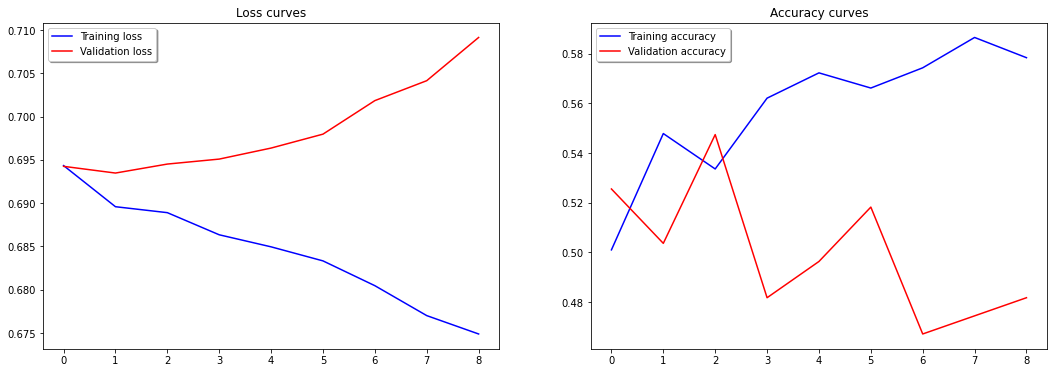

In [ ]:
# Predict on test data
y_hat1_2 = model1_2.predict(X_test_1)

# Find the accuracy of the model. Values greater than 0.5 are considered 1, else 0.
y_hat1_2 = y_hat1_2 > .5

print("CNN inital model accuracy: {}%".format(metrics.accuracy_score(test_5w,y_hat1_2).round(4)*100))

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

axs[0].plot(model1_2_hist.history['loss'], color='b', label='Training loss')
axs[0].plot(model1_2_hist.history['val_loss'], color='r', label='Validation loss')

axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)

axs[1].plot(model1_2_hist.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(model1_2_hist.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)

plt.show()

Provide description of RNN 

In [ ]:
# Split data into training, validation and test sets 
column_indices = {name: i for i, name in enumerate(Ford.columns)}

n = len(Ford)
X_train = Ford[0:int(n*0.9)]
X_val = Ford[int(n*0.7):int(n*0.9)]
X_test = Ford[int(n*0.9):]

y_train = target_3[0:int(n*0.9)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [ ]:
# Normalize the data
X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = Ford.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = Ford.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = Ford.columns)

In [ ]:
def kbest_creator(k):
    """
    returns list of k best features and the number of efficient principle compents to use with said k features
    """
    # apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    best_fit = bestfeatures.fit(X_train, y_train)
    best_scores = pd.DataFrame(best_fit.scores_)
    best_columns = pd.DataFrame(Ford.columns)
    
    # concatenate the dataframes for better visualization
    features_score = pd.concat([best_columns, best_scores], axis=1)
    features_score.columns = ['Features', 'Score']  # naming the dataframe columns
    feats = list(features_score.nlargest(k, 'Score')['Features'])

    pca = PCA().fit(X_train[feats])
    pca_scores = np.cumsum(pca.explained_variance_ratio_) * 100
    res = next(x for x, val in enumerate(pca_scores) if val > 90) 
    res = res +1
    res
    
    return feats, res


In [ ]:
feats, pcs = kbest_creator(40)

# 15 compenents explain 90% 
pca_kb = PCA(n_components = pcs)
X_train_kb = pd.DataFrame(pca_kb.fit_transform(X_train[feats]))
X_val_kb = pd.DataFrame(pca_kb.fit_transform(X_val[feats]))
X_test_kb = pd.DataFrame(pca_kb.fit_transform(X_test[feats]))

# Apply window formatting, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_kb,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_kb, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_kb,y_test) 

print(X_train_1.shape, train_5w.shape)
print(X_val_1.shape, val_5w.shape)
print(X_test_1.shape, test_5w.shape)

(633, 5, 15) (633,)
(137, 5, 15) (137,)
(66, 5, 15) (66,)


C:\Users\Alexander.Ferrante\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
# Model using the PCA od 40 SelectKBest features 
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [ ]:
# Compile Model
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
              
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 8)              768       
                                                                 
 batch_normalization (BatchN  (None, 5, 8)             32        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 5, 8)              544       
                                                                 
 batch_normalization_1 (Batc  (None, 5, 8)             32        
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 batch_normalization_2 (Batc  (None, 8)                3

In [ ]:
# Fit model 
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation

history = model.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w))

Epoch 1/100
13/13 [==============================] - 7s 61ms/step - loss: 2.8102 - accuracy: 0.5340 - val_loss: 2.6140 - val_accuracy: 0.4599
Epoch 2/100
13/13 [==============================] - 0s 13ms/step - loss: 2.5875 - accuracy: 0.5355 - val_loss: 2.4495 - val_accuracy: 0.5255
Epoch 3/100
13/13 [==============================] - 0s 13ms/step - loss: 2.3911 - accuracy: 0.5482 - val_loss: 2.2968 - val_accuracy: 0.5255
Epoch 4/100
13/13 [==============================] - 0s 13ms/step - loss: 2.2313 - accuracy: 0.5450 - val_loss: 2.1553 - val_accuracy: 0.5401
Epoch 5/100
13/13 [==============================] - 0s 12ms/step - loss: 2.0827 - accuracy: 0.5798 - val_loss: 2.0255 - val_accuracy: 0.5401
Epoch 6/100
13/13 [==============================] - 0s 13ms/step - loss: 1.9571 - accuracy: 0.5750 - val_loss: 1.9068 - val_accuracy: 0.5255
Epoch 7/100
13/13 [==============================] - 0s 13ms/step - loss: 1.8424 - accuracy: 0.5924 - val_loss: 1.7990 - val_accuracy: 0.5328
Epoch 

In [ ]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 70.6161%
test accuracy = 50.0%
test error = 33 out of 66 examples


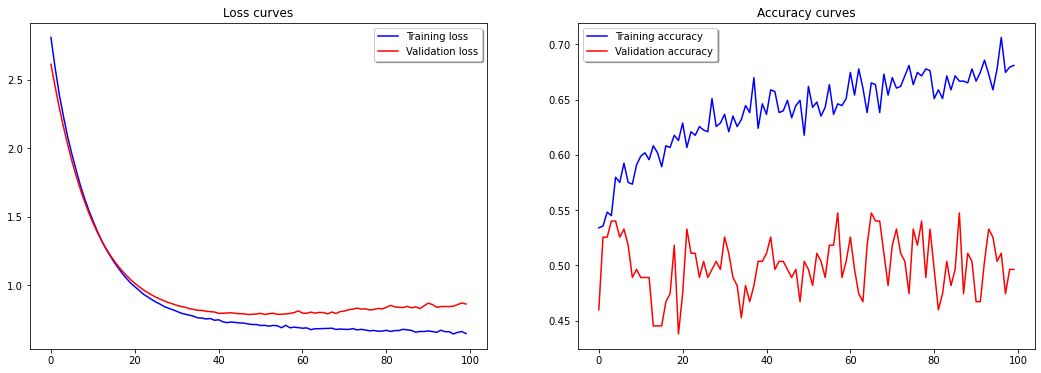

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
# Display the predictioned vs actuals 
y_hat = model.predict(X_test_1, batch_size=50, verbose=1)
#score = sum(y_hat == y_test) / len(y_test)
#print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2017-01-02', end='2018-06-19', freq='B')
for i in range(y_hat.shape[0]):
    print(index[i], y_hat[i], test_5w[i])

2/2 [==============================] - 1s 4ms/step
2017-01-02 00:00:00 [0.91148275] 1
2017-01-03 00:00:00 [0.7908968] 0
2017-01-04 00:00:00 [0.3051197] 0
2017-01-05 00:00:00 [0.5898801] 0
2017-01-06 00:00:00 [0.40324372] 1
2017-01-09 00:00:00 [0.07845059] 1
2017-01-10 00:00:00 [0.03774798] 0
2017-01-11 00:00:00 [0.12581652] 1
2017-01-12 00:00:00 [0.6747093] 0
2017-01-13 00:00:00 [0.9021783] 0
2017-01-16 00:00:00 [0.9198288] 1
2017-01-17 00:00:00 [0.24044833] 1
2017-01-18 00:00:00 [0.06340772] 1
2017-01-19 00:00:00 [0.07416627] 1
2017-01-20 00:00:00 [0.18310702] 0
2017-01-23 00:00:00 [0.4013644] 0
2017-01-24 00:00:00 [0.48780796] 0
2017-01-25 00:00:00 [0.36813882] 0
2017-01-26 00:00:00 [0.176905] 0
2017-01-27 00:00:00 [0.09006059] 0
2017-01-30 00:00:00 [0.04057518] 0
2017-01-31 00:00:00 [0.8312367] 0
2017-02-01 00:00:00 [0.7457682] 1
2017-02-02 00:00:00 [0.718813] 1
2017-02-03 00:00:00 [0.44349346] 1
2017-02-06 00:00:00 [0.62839234] 0
2017-02-07 00:00:00 [0.5359686] 0
2017-02-08 00:00:0

[Text(0, 0.5, 'True: 0'), Text(0, 1.5, 'True: 1')]

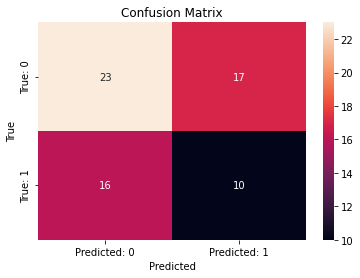

In [ ]:
# Display confusion matrix results
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
predicted = model.predict(X_test_1)
predicted = (predicted > 0.5)

confusion = confusion_matrix(test_5w, predicted)

sns.heatmap(confusion, annot=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Predicted: 0", "Predicted: 1"])
ax.yaxis.set_ticklabels(["True: 0", "True: 1"])


In [ ]:
feats, pcs = kbest_creator(26)

pca_kb = PCA(n_components = pcs)
X_train_kb = pd.DataFrame(pca_kb.fit_transform(X_train[feats]))
X_val_kb = pd.DataFrame(pca_kb.fit_transform(X_val[feats]))
X_test_kb = pd.DataFrame(pca_kb.fit_transform(X_test[feats]))

# Apply window formatting, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_kb,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_kb, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_kb,y_test) 

print(X_train_1.shape, train_5w.shape)
print(X_val_1.shape, val_5w.shape)
print(X_test_1.shape, test_5w.shape)

(633, 5, 12) (633,)
(137, 5, 12) (137,)
(66, 5, 12) (66,)


C:\Users\Alexander.Ferrante\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [ ]:
# Same model structure as inital model 
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [ ]:
# Compile Model
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
              
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 8)              672       
                                                                 
 batch_normalization_3 (Batc  (None, 5, 8)             32        
 hNormalization)                                                 
                                                                 
 lstm_4 (LSTM)               (None, 5, 8)              544       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 8)             32        
 hNormalization)                                                 
                                                                 
 lstm_5 (LSTM)               (None, 8)                 544       
                                                                 
 batch_normalization_5 (Batc  (None, 8)               

In [ ]:
# Fit model 
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

history = model.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w))

Epoch 1/100
13/13 [==============================] - 7s 68ms/step - loss: 2.9577 - accuracy: 0.5008 - val_loss: 2.5446 - val_accuracy: 0.4818
Epoch 2/100
13/13 [==============================] - 0s 12ms/step - loss: 2.7006 - accuracy: 0.5150 - val_loss: 2.4079 - val_accuracy: 0.4964
Epoch 3/100
13/13 [==============================] - 0s 12ms/step - loss: 2.4855 - accuracy: 0.5024 - val_loss: 2.2794 - val_accuracy: 0.4891
Epoch 4/100
13/13 [==============================] - 0s 13ms/step - loss: 2.3218 - accuracy: 0.5071 - val_loss: 2.1598 - val_accuracy: 0.4891
Epoch 5/100
13/13 [==============================] - 0s 12ms/step - loss: 2.1617 - accuracy: 0.5387 - val_loss: 2.0485 - val_accuracy: 0.4380
Epoch 6/100
13/13 [==============================] - 0s 13ms/step - loss: 2.0257 - accuracy: 0.5561 - val_loss: 1.9451 - val_accuracy: 0.4599
Epoch 7/100
13/13 [==============================] - 0s 15ms/step - loss: 1.9224 - accuracy: 0.5498 - val_loss: 1.8502 - val_accuracy: 0.4453
Epoch 

In [ ]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 68.8784%
test accuracy = 54.5455%
test error = 30 out of 66 examples


Relative to the inital RNN model, the one directly above appears to be slighly more accruacte, and experiencing less overfitting. This seems to be a function of the number of features included in the PCA decomposition. Perhaps we were a little overzelous with our model structure, lets see what happens when we simplify and reduce the amount of hidden layers. 

In [ ]:
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 32, 32, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()

model.add(LSTM(units=LAYERS[2], input_shape=(n_steps, n_features),
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
              
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 32)                5760      
                                                                 
 batch_normalization_8 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,921
Trainable params: 5,857
Non-trainable params: 64
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train_1, train_5w,
                    epochs=100,
                    validation_data=(X_val_1, val_5w))

Epoch 1/100
20/20 [==============================] - 2s 20ms/step - loss: 2.3467 - accuracy: 0.4961 - val_loss: 1.9429 - val_accuracy: 0.5109
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 1.8418 - accuracy: 0.5150 - val_loss: 1.6440 - val_accuracy: 0.5036
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 1.5361 - accuracy: 0.5371 - val_loss: 1.4213 - val_accuracy: 0.5182
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 1.3298 - accuracy: 0.5387 - val_loss: 1.2562 - val_accuracy: 0.5182
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 1.1841 - accuracy: 0.5513 - val_loss: 1.1332 - val_accuracy: 0.5255
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 1.0711 - accuracy: 0.5750 - val_loss: 1.0436 - val_accuracy: 0.5182
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.9889 - accuracy: 0.5719 - val_loss: 0.9737 - val_accuracy: 0.5255
Epoch 8/100


In [ ]:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 58.1359%
test accuracy = 53.0303%
test error = 31 out of 66 examples


[Text(0, 0.5, 'True: 0'), Text(0, 1.5, 'True: 1')]

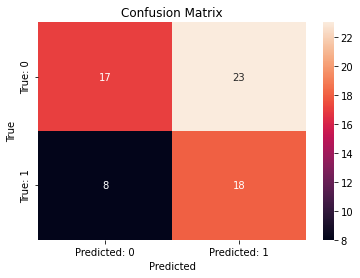

In [ ]:
# Display confusion matrix results
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
predicted = model.predict(X_test_1)
predicted = (predicted > 0.5)

confusion = confusion_matrix(test_5w, predicted)

sns.heatmap(confusion, annot=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Predicted: 0", "Predicted: 1"])
ax.yaxis.set_ticklabels(["True: 0", "True: 1"])

Interesting, the simplistic model which included fewer SelectKBest features had a similar level of accuracy and experienced less overfitting. We can confirm this since the training accuracy and testing accuracy are growing closer while the loss functions are decreasing (improving). 